# Final Report Notebook

*This is our main program for importing data, manipulating it, and exporting it to .CSV files used for creating a network graph of COVID infection. We chose to import data from a John's Hopkins dataset that we can derive infection rate of different U.S. counties from. In this project we are specifically looking at the state of New York* 

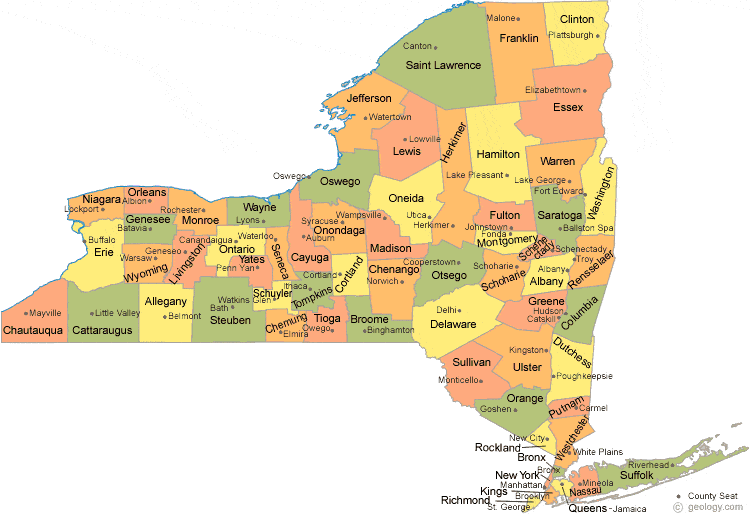

In [127]:
from IPython.display import Image

Image(filename="new-york-county-map.gif")

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime as dt
import numpy as np
import math
from sklearn import linear_model
import joblib
import warnings
from IPython.display import display
from IPython.display import Video
from IPython.core.interactiveshell import InteractiveShell

*The method below is used to filter data from a Pandas dataframe based on the state parameter given. This is useful when looking to pull specific state data.*

In [129]:
# useful for filtering data from a certain state or province
def filter_data_by_state(data, state):
    data = data[data['Province_State'] == state]
    return data[data['Admin2'] != 'Unassigned']

*The create_nodes_for_data method takes in a Pandas dataframe, and populates a Networkx graph with nodes created with county names.*

In [130]:
# makes nodes in graph for each row in data
def create_nodes_for_data(data):
    G = nx.Graph()
    for index, row in data.iterrows():
        G.add_node(str(row.iloc[5]))
    return G

*The populate_data_into_nodes_state method is used to pull data from a Pandas dataframe and populate each node in the initialized Networkx graph 'G' with important data like latitude, longitude, time of first infection, and so on. The method will also assign each node a relative time, based on first infection.*

In [131]:
# fills nodes with data and assign relative_time
def populate_data_into_nodes_state(G, data, logistic_curve=False, pop_data=None, load_curves=False,
                                   max_iterations=10000):
    already_infected = set()
    logistic_curves = dict()
    time = 0
    start_date = dt.datetime(2020, 1, 22)
    current_date = dt.datetime(2020, 1, 22)
    end_date = dt.datetime(2020, 5, 27)  # change as more data comes in
    while current_date <= end_date:
        day_data = data[data[current_date.strftime('%#m/%#d/%y')] > 0]
        was_added = False
        for index, row in day_data.iterrows():
            county = str(row.iloc[5])
            if county not in already_infected:
                G.nodes[county]['relative_time'] = time
                G.nodes[county]['real_time'] = current_date.strftime('%#m/%#d/%y')
                G.nodes[county]['lat'] = row.iloc[8]
                G.nodes[county]['long'] = row.iloc[9]
                G.nodes[county]['data'] = row.iloc[12:]
                if pop_data is not None:
                    pop = pop_data[pop_data['County'] == county]
                    if not pop.empty:
                        G.nodes[county]['pop'] = pop['Population']
                    else:
                        G.nodes[county]['pop'] = 2000  # give unknown counties 2000 population
                if logistic_curve:
                    if load_curves:
                        load_logistic_curve(county, logistic_curves)
                    else:
                        logistic_curves[county] = fit_logistic_curve(G.nodes[county], max_iterations)
                already_infected.add(county)
                was_added = True
        if was_added:
            time += 1
        current_date += dt.timedelta(days=1)
    return time, logistic_curves

*The create_edges_for_graph_first_infection method is used to create edged between the nodes in a Networkx graph, based on the relative time of infection, and the distance between the two counties.*

In [132]:
# uses relative_time field to determine where to place edges, distance can be limited but by default is not
def create_edges_for_graph_first_infection(G, max_relative_time, distance_limit):
    time = 0
    prev_nodes = []
    temp = []
    while time <= max_relative_time:
        for node in G.nodes(data=True):
            if 'relative_time' in node[1] and node[1]['relative_time'] == time:
                for prev_node in prev_nodes:
                    distance = calculate_distance(prev_node, node)
                    if distance <= distance_limit:
                        G.add_edge(prev_node[0], node[0], weight=distance)
                temp.append(node)
        prev_nodes = temp.copy()
        temp.clear()
        time += 1

*Much like the above method, the create_edges_for_graph_threshold_distance method checks if the number of infected in the county, with proportion to the distance to the next county, meets a certain specified threshold. If it does meet this threshold, the method will create an edge between the two counties.*

In [133]:
# uses real_time and distance to determine where to place edges threshold and distance_limit must be provided
def create_edges_for_graph_threshold_distance(G, threshold, distance_limit):
    start_date = dt.datetime(2020, 1, 22)
    current_date = dt.datetime(2020, 1, 22)
    end_date = dt.datetime(2020, 5, 27)
    prev_nodes = []
    while current_date <= end_date:
        for node in G.nodes(data=True):
            if 'real_time' in node[1] and node[1]['real_time'] == current_date.strftime('%#m/%#d/%y'):
                for prev_node in prev_nodes:
                    distance = calculate_distance(prev_node, node)
                    day = int(current_date.strftime('%#j')) - int(start_date.strftime('%#j'))
                    weight = prev_node[1]['data'][int(day)]/distance
                    if weight >= threshold and distance <= distance_limit:
                        G.add_edge(prev_node[0], node[0], weight=weight)
                prev_nodes.append(node)
        current_date += dt.timedelta(days=1)

*This method uses a logistic regression model from SciKit-Learn to predict a fitted logistic curve for each county, and then runs a simulation to create edges in the network.*

*This simulation is based off a radius of infection, calculated by the logistic regression model. If a county is within the infection radius distance of an already infected county, that county will also begin to become infected.*

In [134]:
# uses regression to fit a logistic growth curve to the each county and then run a simulation to create edges
def create_edges_for_graph_logistic_simulation(G, logistic_curves, time_limit, radius_weight):
    time = np.zeros((1, 1), dtype=int)
    infected = []
    found_first = False
    while time[0][0] <= time_limit:
        if not found_first:
            for node in G.nodes(data=True):
                if node[0] in logistic_curves and logistic_curves[node[0]].predict(time)[0] > 1:
                    infected.append(node)
                    found_first = True
                    break
        time[0][0] += 1
        if found_first:
            break
    while time[0][0] <= time_limit:
        for node1 in infected:
            radius = radius_weight * logistic_curves[node1[0]].predict(time)[0]  # / float(node1[1]['pop'])
            for node2 in G.nodes(data=True):
                if node2 in infected:
                    continue
                if 'lat' in node2[1]:
                    distance = calculate_distance(node1, node2)
                    if distance < radius:
                        G.add_edge(node1[0], node2[0], weight=distance)
                        infected.append(node2)

        time[0][0] += 1

*The below method is key for creating our infection simulation. This will take in a node from the Networkx graph, and use the Scikit-Learn python library to create a logistic regression model to fit logistic curves to the infection data in that node. It will then return the logistic curve.*

*The logistic regression model will the node to fit a curve based on the data within that node. It will optimize the data to the logistic function:* $${f(x) = \frac{L}{1 + e^{-k(x-x_0)}}}$$

*where* $x_0$ *is the x value of thei sigmoid midpoint, L is the curves maximum value, and k is the growth rate of the curve.*

In [135]:
# uses sklearn to fit a logistic growth curve to the data in the node
def fit_logistic_curve(node, max_iterations):
    x = np.linspace(0, len(node['data'])-1, len(node['data']), dtype=int)
    y = np.zeros(len(x), dtype=int)
    for i in range(0, len(y)):
        y[i] = int(node['data'][i])
    x = x[:, np.newaxis]
    warnings.filterwarnings("ignore")
    clf = linear_model.LogisticRegression(C=1e5, max_iter=max_iterations)
    clf.fit(x, y)
    # # used to plot logistic curves
    # plt.figure(1, figsize=(4, 3))
    # # plt.clf()
    # x = np.linspace(0, 250, 251)
    # x = x[:, np.newaxis]
    # plt.plot(x, clf.predict(x))
    # plt.show()
    return clf

*This method is used to save the produced logistic curves to a certain directory. The default directory is logistic_curves, but this can be modified to save to different locations.*

In [136]:
# saves logistic_curves to a directory named logistic_curves and a modifier can be added for different save locations
def save_logistic_curves(logistic_curves, modifier=''):
    if modifier is not '':
        modifier = '_' + modifier
    for key in logistic_curves:
        joblib.dump(logistic_curves[key], 'logistic_curves%s/%s.pkl' % (modifier, key))

*This method will load logistic curves from a certain directory. The default directory is logistic_curves, but this can be modified to load from different locations.*

In [137]:
# loads logistic curves from a directory named logistic_curves and a modifier can be added for different load locations
def load_logistic_curve(county, logistic_curves, modifier=''):
    if modifier is not '':
        modifier = '_' + modifier
    logistic_curves[county] = joblib.load('logistic_curves%s/%s.pkl' % (modifier, county))

*This method will run previously defined methods to create a Networkx graph of the spread of Covid-19 based on first infection in a location and connects location which were infected next.*

In [138]:
def create_graph_first_infected(data, distance_limit=30000):
    G = create_nodes_for_data(data)
    max_time = populate_data_into_nodes_state(G, data)[0]
    create_edges_for_graph_first_infection(G, max_time, distance_limit)
    return G

*This method will run previously defined methods in order to create a networkx graph of the spread Covid-19 based on a threshold and distance_limit. This method may be better on larger sample sizes so far locations are not infecting each other*

In [139]:
def create_graph_infected_distance(data, threshold=2.5, distance_limit=75):
    G = create_nodes_for_data(data)
    populate_data_into_nodes_state(G, data)
    create_edges_for_graph_threshold_distance(G, threshold=threshold, distance_limit=distance_limit)
    return G

*This method will run previously defined methods in order to create a networkx graph of the spread Covid-19 based on a Logistic simulation*

In [140]:
def create_graph_logistic_simulation(data, time_limit=250, radius_weight=.5):
    G = create_nodes_for_data(data)
    pop_data = pd.read_csv('pop_ny_data_2020.csv')
    max_relative_time, logistic_curves = populate_data_into_nodes_state(G, data, logistic_curve=True, pop_data=pop_data,
                                                                        max_iterations=50000)
    create_edges_for_graph_logistic_simulation(G, logistic_curves, time_limit, radius_weight)
    save_logistic_curves(logistic_curves)
    return G

*This method will run previously defined methodsin order to create a networkx graph of the spread Covid-19 based on a logistic simulation loaded from saved logistic curves.*

In [141]:
def create_graph_logistic_simulation_load_lc(data, time_limit=250, radius_weight=.5):
    G = create_nodes_for_data(data)
    pop_data = pd.read_csv('pop_ny_data_2020.csv')
    max_relative_time, logistic_curves = populate_data_into_nodes_state(G, data, logistic_curve=True, pop_data=pop_data,
                                                                        load_curves=True)
    create_edges_for_graph_logistic_simulation(G, logistic_curves, time_limit, radius_weight)
    return G

*This method converts the networkx graph created to two csv files which can be imported into cytoscape.*

In [142]:
def convert_to_csv(G):
    output_node = 'county,relative_time,real_time,lat,long,degree,degree_centrality,closeness_centrality\n'
    output_edge = 'source,target,distance\n'
    for node in G.nodes(data=True):
        if 'relative_time' in node[1]:
            output_node += '%s,%s,%s,%s,%s,%s,%s,%s\n' % (node[0], node[1]['relative_time'], node[1]['real_time'],
                                                          node[1]['lat'], node[1]['long'], node[1]['degree'],
                                                          node[1]['degree_centrality'], node[1]['closeness_centrality'])
    for edge in G.edges(data=True):
        output_edge += '%s,%s,%s\n' % (edge[0], edge[1], edge[2]['weight'])

    return output_node, output_edge

*The convert_to_cyto_layout method is used to convert the cytoscape data and network csv files into csv files usable for the cytoscape coordinateLayout plugin.*

In [143]:
def convert_to_cyto_layout(node_file_in, edge_file_in, node_file_out, edge_file_out, scale=25):
    nodes_out_text = ''
    edges_out_text = ''
    nodes_in = pd.read_csv(node_file_in)
    cities = dict()
    i = 1
    for index, row in nodes_in.iterrows():
        cities[row.iloc[0]] = i
        nodes_out_text += '%s %s %s %s %s\n' % (i, str(row.iloc[0]).replace(' ', '_'), '1', int(row.iloc[3])/scale,
                                                int(row.iloc[4])/scale)
        i += 1
    edges_in = pd.read_csv(edge_file_in)
    for index, row in edges_in.iterrows():
        edges_out_text += '%s %s %s\n' % (cities[row.iloc[0]], cities[row.iloc[1]], row.iloc[2])

    with open(node_file_out, 'w') as f:
        f.write(nodes_out_text)
        f.close()

    with open(edge_file_out, 'w') as f:
        f.write(edges_out_text)
        f.close()

*These two methods are used to calculate the distance between two nodes. This calculation uses the latitude and longitude of the counties that the nodes represent.*

In [144]:
# calculates the distance between two nodes
def calculate_distance(node1, node2):
    lat1 = node1[1]['lat']
    lat2 = node2[1]['lat']
    lon1 = node1[1]['long']
    lon2 = node2[1]['long']
    R = 3958.5  # radius of earth in miles
    dlat = deg_to_rad(lat2 - lat1)
    dlon = deg_to_rad(lon2 - lon1)
    a = (math.sin(dlat/2))**2 + math.cos(deg_to_rad(lat1)) * math.cos(deg_to_rad(lat2)) * (math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return math.floor(R * c)


# helper function for calculate distance
def deg_to_rad(deg):
    return deg * (math.pi / 180)

*This method is used to calculate useful statistics of nodes in the graph such as, centrality and degree.*

In [145]:
def calculate_node_stats(G):
    for item in nx.degree_centrality(G).items():
        G.nodes[item[0]]['degree_centrality'] = item[1]
    for item in nx.closeness_centrality(G).items():
        G.nodes[item[0]]['closeness_centrality'] = item[1]
    for item in G.degree():
        G.nodes[item[0]]['degree'] = item[1]

*This method is used to write data from the Networkx graph to a csv format, and will then write it to a local directory file.*

In [146]:
def write_csv(filename, G):
    csv = convert_to_csv(G)
    with open('%s_network.csv' % filename, 'w') as f:
        f.write(csv[1])
        f.close()

    with open('%s_data.csv' % filename, 'w') as f:
        f.write(csv[0])
        f.close()

*The main method of our program. This will read in the John's Hopkins csv data into a Pandas dataframe, will filter that dateframe to the state of New York, and will use the methods above to create various visualizations.*

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20
1833,84036001,US,USA,840,36001.0,Albany,New York,US,42.600603,-73.977239,...,1834,1843,1860,1882,1900,1920,1930,1941,1953,1961
1834,84036003,US,USA,840,36003.0,Allegany,New York,US,42.257484,-78.027505,...,45,45,45,48,48,49,49,51,51,51
1835,84036005,US,USA,840,36005.0,Bronx,New York,US,40.852093,-73.862828,...,0,0,0,0,0,0,0,0,0,0
1836,84036007,US,USA,840,36007.0,Broome,New York,US,42.159032,-75.813261,...,557,561,566,574,578,589,593,605,613,620
1837,84036009,US,USA,840,36009.0,Cattaraugus,New York,US,42.247782,-78.679231,...,86,87,88,89,89,90,91,92,92,94
1838,84036011,US,USA,840,36011.0,Cayuga,New York,US,42.912617,-76.557316,...,89,90,91,92,93,96,96,98,100,101
1839,84036013,US,USA,840,36013.0,Chautauqua,New York,US,42.227692,-79.366918,...,82,83,84,85,86,89,95,97,99,101
1840,84036015,US,USA,840,36015.0,Chemung,New York,US,42.138911,-76.763880,...,137,137,137,137,137,137,137,137,137,137
1841,84036017,US,USA,840,36017.0,Chenango,New York,US,42.494300,-75.608876,...,130,132,133,133,133,133,133,133,133,134
1842,84036019,US,USA,840,36019.0,Clinton,New York,US,44.745309,-73.678754,...,95,95,95,96,97,97,97,97,97,97


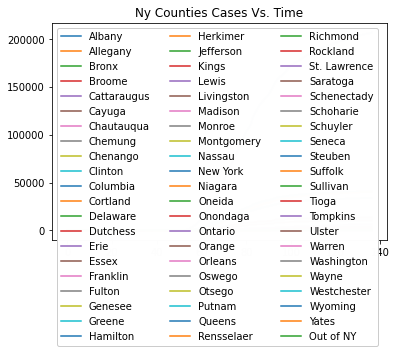

In [147]:
def main():
    data = pd.read_csv('time_series_covid19_confirmed_US.csv')

    new_york = filter_data_by_state(data, 'New York')
    display(new_york)
    
    # visualizes data in graph vs time
    dates = list(range(0, len(data.columns[12:].values)))
    plt.figure()
    for index, row in new_york.iterrows():
        plt.plot(dates, row.iloc[12:], label=row.iloc[5])
    plt.title(str.title('NY Counties cases vs. time'))
    plt.legend(framealpha=2, frameon=True, ncol=3, loc='upper left')
    plt.show()

    # creates graph of first infection
    G = create_graph_first_infected(new_york)
    calculate_node_stats(G)
    write_csv('first_infection', G)

    # creates graph of threshold distance
    H = create_graph_infected_distance(new_york)
    calculate_node_stats(H)
    write_csv('threshold_distance', H)

    # creates graph of logistic simulation
    J = create_graph_logistic_simulation(new_york)
    # J = create_graph_logistic_simulation_load_lc(new_york, radius_weight=1)
    calculate_node_stats(J)
    write_csv('logistic_simulation', J)


    # this will make files for the coordinateLayout plugin for cytoscape for each graph
    convert_to_cyto_layout('first_infection_data.csv', 'first_infection_network.csv',
                           'first_infection_data_cyto_layout.csv', 'first_infection_network_cyto_layout.csv')
    convert_to_cyto_layout('threshold_distance_data.csv', 'threshold_distance_network.csv',
                           'threshold_distance_data_cyto_layout.csv', 'threshold_distance_network_cyto_layout.csv')
    convert_to_cyto_layout('logistic_simulation_data.csv', 'logistic_simulation_network.csv',
                           'logistic_simulation_data_cyto_layout.csv', 'logistic_simulation_network_cyto_layout.csv')


if __name__ == '__main__':
    main()

*Here is a video of our final simulation visualization in cytoscape. It shows of COVID theoretically spread from county to county in the state of New York.*

In [148]:
Video('NewGraphDemo.mp4')